In [1]:
'''
Googleドライブからnpyファイルを読み込む
実行後、URLが表示されるので、自分のアカウントを認証する
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
classes = ['cat', 'dog']
num_classes = len(classes)
image_size = 224

# データの読込
X_train, X_test, y_train, y_test = np.load('/content/drive/My Drive/catdog_cnn_train.npy', allow_pickle=True)

In [4]:
len(np.where(y_train == 0)[0])
print(X_train.shape)
print(y_train.shape)
print(len(np.where(y_train == 0)[0]),len(np.where(y_train == 1)[0]))

(3000, 224, 224, 3)
(3000,)
1492 1508


In [5]:
y_train = np_utils.to_categorical(y_train, num_classes) # 0 or 1 -> [0,1]
y_test = np_utils.to_categorical(y_test, num_classes)

# 正則化
X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0

In [6]:
# 訓練データ、評価データ数の確認
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3000, 224, 224, 3) (3000, 2)
(1000, 224, 224, 3) (1000, 2)


In [7]:
# ネットワークの構築
model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(image_size,image_size, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

model.summary()

for layer in model.layers[:15]:
    layer.trainable = False

opt = Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=32, 
                    epochs=10)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [8]:
score = model.evaluate(X_test, y_test, batch_size=32)
print(score)

32/32 [==============================] - 4s 133ms/step - loss: 0.1468 - accuracy: 0.9530
[0.1468377411365509, 0.953000009059906]


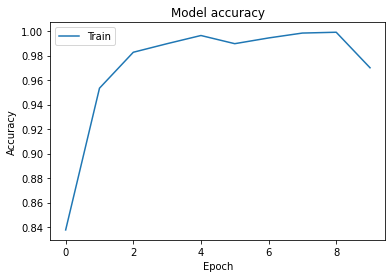

In [9]:
# 学習率の可視化
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [10]:
# モデルの保存
model.save("/content/drive/My Drive/vgg16_transfer.h5")